# Fake Image Detection using Error Level Analysis (ELA) and CNN

This notebook implements a Convolutional Neural Network (CNN) to detect fake images by analyzing their compression artifacts using Error Level Analysis (ELA).

### Prerequisite: Dataset Structure
Ensure your dataset is uploaded and structured as follows:
```
dataset/
├── train/
│   ├── real/
│   └── fake/
├── validation/
│   ├── real/
│   └── fake/
└── test/
    ├── real/
    └── fake/
```

In [1]:
# If using Google Colab, uncomment the following lines to mount your drive
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageEnhance
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## 1. Configuration

In [ ]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 50
# Update this path to point to your dataset location
DATASET_PATH = './dataset'

## 2. Error Level Analysis (ELA) Function
This function resaves the image at a specific quality level and calculates the difference (error) between the original and the compressed version.

In [4]:
def convert_to_ela_image(path, quality=90):
    temp_filename = "temp_ela.jpg"

    try:
        image = Image.open(path).convert("RGB")
        image.save(temp_filename, "JPEG", quality=quality)

        compressed = Image.open(temp_filename)
        ela_img = ImageChops.difference(image, compressed)

        extrema = ela_img.getextrema()
        max_diff = max([ex[1] for ex in extrema]) or 1
        scale = 255.0 / max_diff

        ela_img = ImageEnhance.Brightness(ela_img).enhance(scale)
        return ela_img.resize(IMAGE_SIZE)

    except Exception as e:
        print(f"[ELA ERROR] {path}: {e}")
        return None

## 3. Data Loading Helper

In [5]:
def load_split(split_path):
    X = []
    Y = []

    classes = ["real", "fake"]

    for label, class_name in enumerate(classes):
        folder = os.path.join(split_path, class_name)

        if not os.path.isdir(folder):
            print(f"[WARNING] Missing folder: {folder}")
            continue

        print(f"Loading '{class_name}' images from {split_path} ...")

        for filename in os.listdir(folder):
            if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            img_path = os.path.join(folder, filename)
            ela_img = convert_to_ela_image(img_path)

            if ela_img:
                X.append(np.array(ela_img) / 255.0)
                Y.append(label)

    return np.array(X), to_categorical(Y, 2)

## 4. Load Datasets

In [6]:
print("\n===== LOADING TRAIN DATA =====")
x_train, y_train = load_split(os.path.join(DATASET_PATH, "train"))

print("\n===== LOADING VALIDATION DATA =====")
x_val, y_val = load_split(os.path.join(DATASET_PATH, "validation"))

print("\n===== LOADING TEST DATA =====")
x_test, y_test = load_split(os.path.join(DATASET_PATH, "test"))

print("\nDataset Summary:")
print(f"Train: {len(x_train)} images")
print(f"Validation: {len(x_val)} images")
print(f"Test: {len(x_test)} images")


===== LOADING TRAIN DATA =====
Loading 'real' images from ./dataset\train ...
Loading 'fake' images from ./dataset\train ...

===== LOADING VALIDATION DATA =====
Loading 'real' images from ./dataset\validation ...
Loading 'fake' images from ./dataset\validation ...

===== LOADING TEST DATA =====
Loading 'real' images from ./dataset\test ...
Loading 'fake' images from ./dataset\test ...

Dataset Summary:
Train: 10 images
Validation: 10 images
Test: 10 images


## 5. Build CNN Model

In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')   # real vs fake
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

C:\Users\nisar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,546 (24.86 MB)

 Trainable params: 6,516,546 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Training

In [8]:
if len(x_train) > 0:
    print("\n===== STARTING TRAINING =====")
    history = model.fit(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(x_val, y_val),
        verbose=1
    )
else:
    print("No training data found. Please check your DATASET_PATH.")


===== STARTING TRAINING =====
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6000 - loss: 0.6842 - val_accuracy: 0.5000 - val_loss: 0.6890
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.5000 - loss: 0.7128 - val_accuracy: 0.5000 - val_loss: 0.6990
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5000 - loss: 0.7157 - val_accuracy: 0.5000 - val_loss: 0.6888
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6000 - loss: 0.7145 - val_accuracy: 0.5000 - val_loss: 0.6888
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.4000 - loss: 0.7244 - val_accuracy: 0.5000 - val_loss: 0.6868
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.7000 - loss: 0.6963 - val_accuracy: 0.7000 - val_loss: 0.6872
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.5000 - loss: 0.6916 - val_accuracy: 0.6000 - val_loss: 0.6879
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7000 - loss: 0.6864 - val_

## 7. Performance Visualization

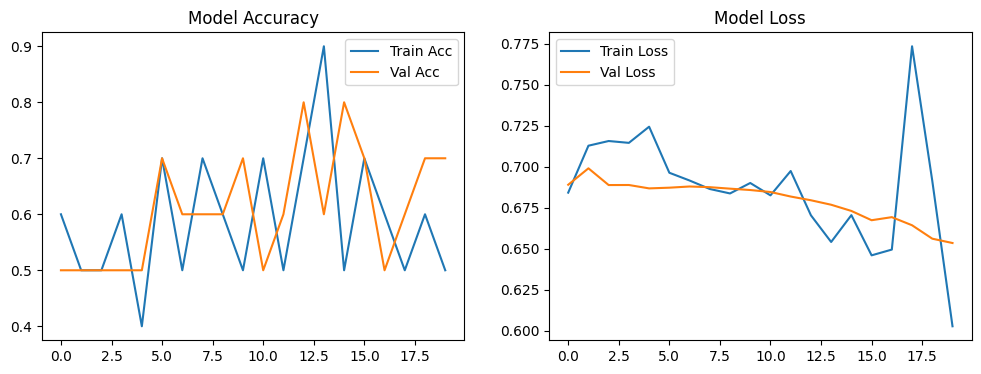

In [9]:
if 'history' in locals():
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title("Model Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Model Loss")
    plt.legend()

    plt.show()

## 8. Evaluation

In [10]:
if len(x_test) > 0:
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f"\n===== TEST ACCURACY: {test_acc:.4f} =====")
else:
    print("No test data available.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7000 - loss: 0.6534

===== TEST ACCURACY: 0.7000 =====


## 9. Prediction Utility


Predicting: ./dataset/test/fake/armycat_forged.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


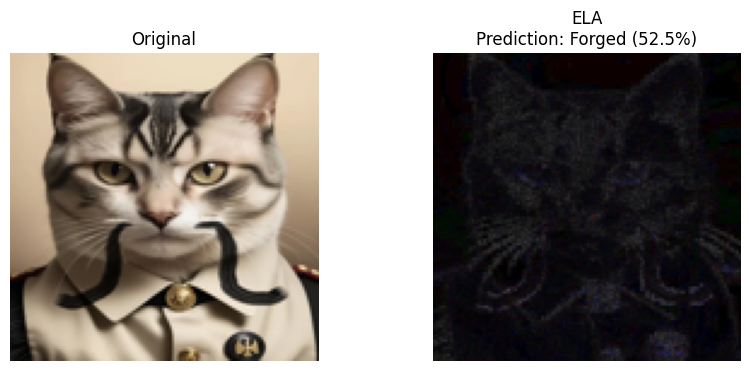

The image is likely Forged (52.5%)
----------------------------------------

Predicting: ./dataset/test/real/armycat.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


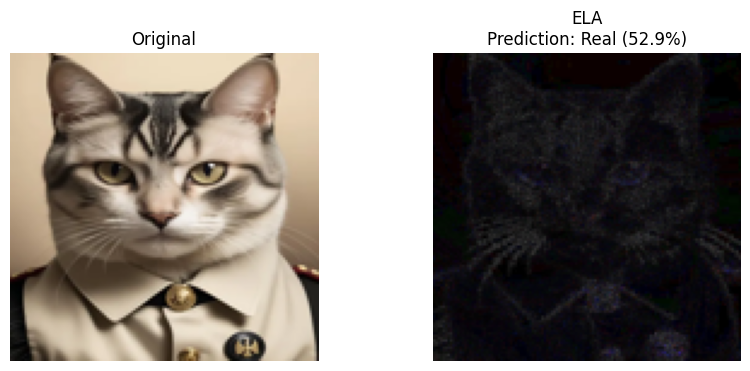

The image is likely Real (52.9%)
----------------------------------------

Predicting: ./dataset/test/fake/grumpycat_forged.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


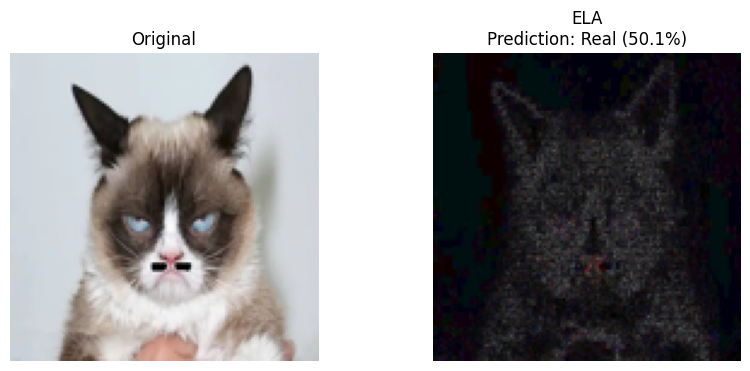

The image is likely Real (50.1%)
----------------------------------------

Predicting: ./dataset/test/real/grumpycat.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


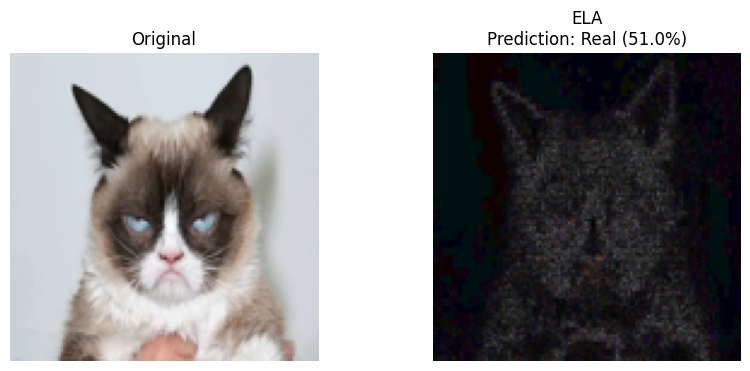

The image is likely Real (51.0%)
----------------------------------------


In [34]:
def predict_image(img_path):
    if not os.path.exists(img_path):
        print("Image not found.")
        return

    print(f"\nPredicting: {img_path}")

    original = Image.open(img_path).resize(IMAGE_SIZE)
    ela_img = convert_to_ela_image(img_path)

    img_array = np.array(ela_img) / 255.0
    img_array = img_array.reshape(1, 128, 128, 3)

    pred = model.predict(img_array)
    label = "Forged" if np.argmax(pred) == 1 else "Real"
    confidence = float(np.max(pred))

    # Show results
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(ela_img)
    plt.title(f"ELA\nPrediction: {label} ({confidence * 100 :.1f}%)")
    plt.axis("off")

    plt.show()
    return label, confidence

import os

# 1. Put your file paths in this list
image_files = [
    "./dataset/test/fake/armycat_forged.jpeg",
    "./dataset/test/real/armycat.jpeg",
    "./dataset/test/fake/grumpycat_forged.jpeg",   
    "./dataset/test/real/grumpycat.jpeg",
]
# 2. Loop through the list
for file_path in image_files:
    if os.path.exists(file_path):
        # Run prediction
        label, confidence = predict_image(file_path)
        
        # Print the result with percentage
        print(f"The image is likely {label} ({confidence * 100:.1f}%)")
        print("-" * 40) # Prints a separator line
    else:
        print(f"File not found: {file_path}")